In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def log_return(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [3]:
def log_volume(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [4]:
def bipower_variation(series, rollingWindow=5):
    '''
    Bipower Variation (BV) is the sum of the product of absolute time series returns
    :param column: price column
    :return: returns bivariate variation
    Barnhorf - Nielse & Shephard 2004 & 2006
    '''
    bv = (series.abs() *series.shift(1).abs()).dropna().rolling(rollingWindow).sum()
    
    return bv

In [5]:
def volatility_increments(series):
    theta = np.sqrt(series)
    Vt = (np.log(theta) - np.log(theta.shift(1))).dropna()
    return Vt

In [6]:
#################################################
# codes for implementing DFA-based analysis
# Exploring asymmetric multifractal cross-correlations of price-volatility and asymmetric volatility dynamics in cryptocurrency markets
#################################################
import numpy as np
import math
###########################################
# MF-ADCCA (includes DFA, DCCA, A-DFA, A-DCCA, MFDFA, MFDCCA, A-MFDFA)
##########################################

import numpy as np

def dcca(x, y, S, m, Q, trend_base=None, skip_agg=False, asymmetry_base='index'):
    """
    Calculate generalized Hurst Exponenet by Multi Fractal Detrended Cross-correlation Analysis.
    Args:
        x(array(float))  : Target time series data.
        y(array(float))  : Target time series data.
        S(array(int))    : Intervals which divides culmative sum time series. Needs to be a positive integer.
        m(int)           : Degree of polynomial fit for each divided segment. Generally, m=2 is recommended.
        Q(array(int))    : fluctuation q-th order.
        trend_base       : designated time series used for defining asymmetric trends.
        skip_agg(bool)   : Whether to use cumsum for profile. If series is stationary (ex. log-returns), then "False". If non-stationary (ex. level data), then "True".
                           It's not needed.
        asymmetry_base  : Which criterion used for defining asymmetric trends.
    Returns:
        array(float)     : Return generalized Hurst exponent (in np.array) of each Q-th order.
    """
    N = len(x)
    assert len(y) == N, '{} segments'.format(len(y))
    if skip_agg:
        X = np.copy(x)
        Y = np.copy(y)
    else:
        X = np.cumsum(x - np.mean(x))
        Y = np.cumsum(y - np.mean(y))

    def Fvs2(v, s, reverse=False):
        """
        (Root Mean Square) ** 2
        F(s, v)
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment_x = X[N - (v-Ns)*s:N - (v-Ns)*s+s]
            segment_y = Y[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment_x = X[(v-1)*s:v*s]
            segment_y = Y[(v-1)*s:v*s]
        coef_x = np.polyfit(ax, segment_x, m)
        coef_y = np.polyfit(ax, segment_y, m)
        fitting_x = np.polyval(coef_x, ax)
        fitting_y = np.polyval(coef_y, ax)
        return np.mean(np.abs(segment_x - fitting_x)*np.abs(segment_y - fitting_y)) # DCCA for x and y

    if asymmetry_base == 'index':
        x_alt = np.exp(np.cumsum(x)) # index-based
    elif asymmetry_base == 'return':
        x_alt = np.copy(x) # return-based
    elif asymmetry_base == 'optional':
        assert type(trend_base) == np.ndarray, 'trend_base is None. designate trend_base.'
        x_alt = np.copy(trend_base) # only for optional. Any series is possible, but designate trend_base.
    else:
        print('not available: index or return or optional only\nPlease choose either and try again')

    def asym_trend(v, s, reverse=False):
        """
        Detecting trend in some data series H
        L_H(x)=a_H+b_H x
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment = x_alt[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment = x_alt[(v-1)*s:v*s]
        coef = np.polyfit(ax, segment, 1) # m=1, y=ax+b (a,b)
        return coef[0] # represents a in y=ax+b

    Fhq = np.zeros(len(Q))
    Fhq_plus = np.zeros(len(Q))
    Fhq_minus = np.zeros(len(Q))
    
    for i, q in enumerate(Q):
        Fqs = np.zeros(len(S))
        Fqs_plus = np.zeros(len(S))
        Fqs_minus = np.zeros(len(S))

        for j, s in enumerate(S):
            Ns = int(N//s)
            segs = np.array([
                [Fvs2(v, s) for v in range(1, Ns + 1)],
                [Fvs2(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(segs) == 2 * Ns, '{} segments'.format(len(segs))

            trend_segs = np.array([
                [asym_trend(v, s) for v in range(1, Ns + 1)],
                [asym_trend(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(trend_segs) == 2 * Ns, '{} segments'.format(len(trend_segs))

            M_plus = np.sum((1+np.sign(trend_segs))/2)
            M_minus = np.sum((1-np.sign(trend_segs))/2)

            # calculate qth fluctuation function
            if q == 0:
                # asymmetric version
                Fqs_plus[j] = np.exp((np.sum(((1+np.sign(trend_segs))/2)*np.log(segs))/M_plus)/2)
                Fqs_minus[j] = np.exp((np.sum(((1-np.sign(trend_segs))/2)*np.log(segs))/M_minus)/2)
                # overall
                Fqs[j] = np.exp(np.mean(np.log(segs))/2)
            else:
                # asymmetric version
                Fqs_plus[j] = (np.sum(((1+np.sign(trend_segs))/2)*(segs ** (q/2))) /M_plus)**(1/q)
                Fqs_minus[j] = (np.sum(((1-np.sign(trend_segs))/2)*(segs ** (q/2)))/M_minus)**(1/q)
                # overall version
                Fqs[j] = np.mean(segs ** (q/2)) ** (1/q)

        coef_plus = np.polyfit(np.log(S), np.log(Fqs_plus), 1)
        coef_minus = np.polyfit(np.log(S), np.log(Fqs_minus), 1)
        coef = np.polyfit(np.log(S), np.log(Fqs), 1)
        Fhq_plus[i] = coef_plus[0]
        Fhq_minus[i] = coef_minus[0]
        Fhq[i] = coef[0]

    # 1~2: estimates for overall trend, 4~5: estimates for positive trend, 7~8: estimates for negative trend
    # S: scales, Fqs: fluctuation functions, Fhq: generalized hurst exponent
    return S, Fqs, Fhq, S, Fqs_plus, Fhq_plus, S, Fqs_minus, Fhq_minus

def basic_dcca(x, y, Q, m=2, trend_base=None, skip_agg=False, observations=100, asymmetry_base='index'):
    """
    polynominal fitting is set to m = 2 at default
    """
    N = len(x)
    s_min = max(20, int(np.floor(N/100)))
    s_max = min(20*s_min, int(np.floor(N/10)))
    s_inc = (s_max - s_min) / (observations-1)
    S = [s_min + int(np.floor(i*s_inc)) for i in range(0, observations)]
    return dcca(x, y, S=S, m=m, Q=Q, trend_base=trend_base, skip_agg=skip_agg, asymmetry_base=asymmetry_base)

def nonlinear_detrend(segment, degree=2):
    """
    Nonlinear detrending using local polynomial regression.
    Args:
        segment (np.array): Segment of the time series.
        degree (int): Degree of the polynomial regression (e.g., 2 for quadratic).
    Returns:
        np.array: Detrended segment.
    """
    n = len(segment)
    x = np.arange(n)
    
    # Fit a polynomial regression
    coefficients = np.polyfit(x, segment, degree)
    
    # Calculate the trend using the polynomial coefficients
    trend = np.polyval(coefficients, x)
    
    # Remove the trend from the segment
    detrended_segment = segment - trend
    
    return detrended_segment

def MFADCCA_Hurst(X, Y, T=252, step=1, Q=np.array([2]), trend_base=None, skip_agg=False, observations=100, asymmetry_base='return'):
    X = np.array(X)
    nX = X.shape[0]
    hurst = np.zeros(nX-T+1)
    hurst_plus = np.zeros(nX-T+1)
    hurst_minus = np.zeros(nX-T+1)
    
    for i in range(0, nX-T+1, step):
        XX = X[i:i+T]
        YY = Y[i:i+T]
        
        # Apply nonlinear detrending to the segments
        XX_detrended = nonlinear_detrend(XX)
        YY_detrended = nonlinear_detrend(YY)
        
        MFADCCA_Hurst = basic_dcca(XX_detrended, YY_detrended, Q=Q, trend_base=trend_base, skip_agg=skip_agg, observations=observations, asymmetry_base=asymmetry_base)
        hurst[i] = MFADCCA_Hurst[2]
        hurst_plus[i] = MFADCCA_Hurst[5]
        hurst_minus[i] = MFADCCA_Hurst[8]
    
    return hurst, hurst_plus, hurst_minus



In [7]:
# read data_set and split them
dataset = pd.read_csv(r"./Datasets/DJI/DJI_QPL.csv")
df = dataset.reset_index(drop=True)
df = df.head(2515)

Close = df['Close']
Volume = df['vol']
# compute Log return and bipower variation for MFADCCA
LogReturn = log_return(Close)         # X
Bv = bipower_variation(LogReturn)     # Y
Vt = volatility_increments(Bv)
vol =  log_volume(Volume) 

Q = np.array([2])

df['log_returns'] = LogReturn         # add to df
df['volatility_increments'] = Vt
df['log_volumes'] = vol

In [8]:
data = df.dropna(axis=0, how='any')

r = data["log_returns"]
v = data["volatility_increments"]
vol = data['log_volumes']

data

Unnamed: 0        Date      Open      High       Low     Close  \
7              7   2010/1/13  10628.09  10709.26  10614.49  10680.77   
8              8   2010/1/14  10680.16  10723.77  10666.86  10710.55   
9              9   2010/1/15  10706.99  10709.94  10561.06  10609.65   
10            10   2010/1/19  10608.37  10729.89  10591.97  10725.43   
11            11   2010/1/20  10719.69  10719.92  10517.30  10603.15   
...          ...         ...       ...       ...       ...       ...   
2006        2006  2017/12/20  24838.09  24852.44  24697.11  24726.65   
2007        2007  2017/12/21  24778.26  24850.91  24766.27  24782.29   
2008        2008  2017/12/22  24764.04  24784.15  24717.51  24754.06   
2009        2009  2017/12/26  24715.84  24778.13  24708.42  24746.21   
2010        2010  2017/12/27  24766.52  24789.52  24731.68  24774.30   

            QPLp1        QPLp2        QPLp3        QPLp4  ...        QPLn16  \
7     10647.40350  10692.77674  10749.11360  10812.36197  ...   9513.883125   
8     10699.56812  10745.16366  10801.77653  10865.33477  ...   9560.494312   
9     10726.44688  10772.15696  10828.91205  10892.62995  ...   9584.511561   
10    10627.64767  10672.93672  10729.16905  10792.30006  ...   9496.230491   
11    10739.16996  10784.93425  10841.75666  10905.55015  ...   9595.880143   
...           ...          ...          ...          ...  ...           ...   
2006  24883.22610  24989.26439  25120.92493  25268.73781  ...  22234.162990   
2007  24823.28737  24929.07025  25060.41364  25207.87047  ...  22180.605330   
2008  24809.04153  24914.76370  25046.03171  25193.40392  ...  22167.876100   
2009  24760.75394  24866.27033  24997.28285  25144.36821  ...  22124.729190   
2010  24811.52604  24917.25879  25048.53995  25195.92691  ...  22170.096100   

            QPLn17        QPLn18        QPLn19        QPLn20        QPLn21  \
7      9429.906263   9345.802308   9261.676347   9177.622468   9093.725027   
8      9476.106024   9391.590020   9307.051903   9222.586220   9138.277741   
9      9499.911278   9415.182959   9330.432470   9245.754598   9161.234325   
10     9412.409445   9328.461542   9244.491674   9160.593753   9076.851980   
11     9511.179513   9426.350694   9341.499679   9256.721367   9172.100841   
...            ...           ...           ...           ...           ...   
2006  22037.907140  21841.354270  21644.749970  21448.314120  21252.243880   
2007  21984.822220  21788.742800  21592.612080  21396.649420  21201.051470   
2008  21972.205340  21776.238460  21580.220300  21384.370090  21188.884390   
2009  21929.439290  21733.853830  21538.217190  21342.748180  21147.642970   
2010  21974.405750  21778.419240  21582.381450  21386.511630  21191.006360   

         vol  log_returns  volatility_increments  log_volumes  
7     202.85     0.005023               0.274387    -0.077974  
8     201.32     0.002784               0.143429    -0.007571  
9     362.93    -0.009465               0.177186     0.589314  
10    192.15     0.010854               0.410472    -0.635934  
11    203.27    -0.011466               0.242878     0.056259  
...      ...          ...                    ...          ...  
2006  341.79    -0.001136              -0.090418     0.019081  
2007  339.53     0.002248              -0.056835    -0.006634  
2008  255.14    -0.001140              -0.139794    -0.285750  
2009  208.29    -0.000317              -0.561273    -0.202881  
2010  225.89     0.001134              -0.368465     0.081117  

[2004 rows x 52 columns]

In [9]:
hurst, hurst_plus, hurst_minus = MFADCCA_Hurst(r, vol, T=256, step=1, Q=Q, trend_base=None, skip_agg=False, observations=100, asymmetry_base='return')

In [10]:
hurst.shape

(1749,)

In [11]:
data['hurst'] = pd.DataFrame(np.array([0] * 1749))
data['hurstp'] = pd.DataFrame(np.array([0] * 1749))
data['hurstm'] = pd.DataFrame(np.array([0] * 1749))

data = data.tail(1749)

data['hurst'] = hurst
data['hurstp'] = hurst_plus
data['hurstm'] = hurst_minus
data = data.reset_index(drop = True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_46868\701051769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurst'] = pd.DataFrame(np.array([0] * 1749))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_46868\701051769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurstp'] = pd.DataFrame(np.array([0] * 1749))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_46868\701051769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [12]:
data.to_csv(r'./Datasets/DJI/DJI_nlMFADCCA.csv')

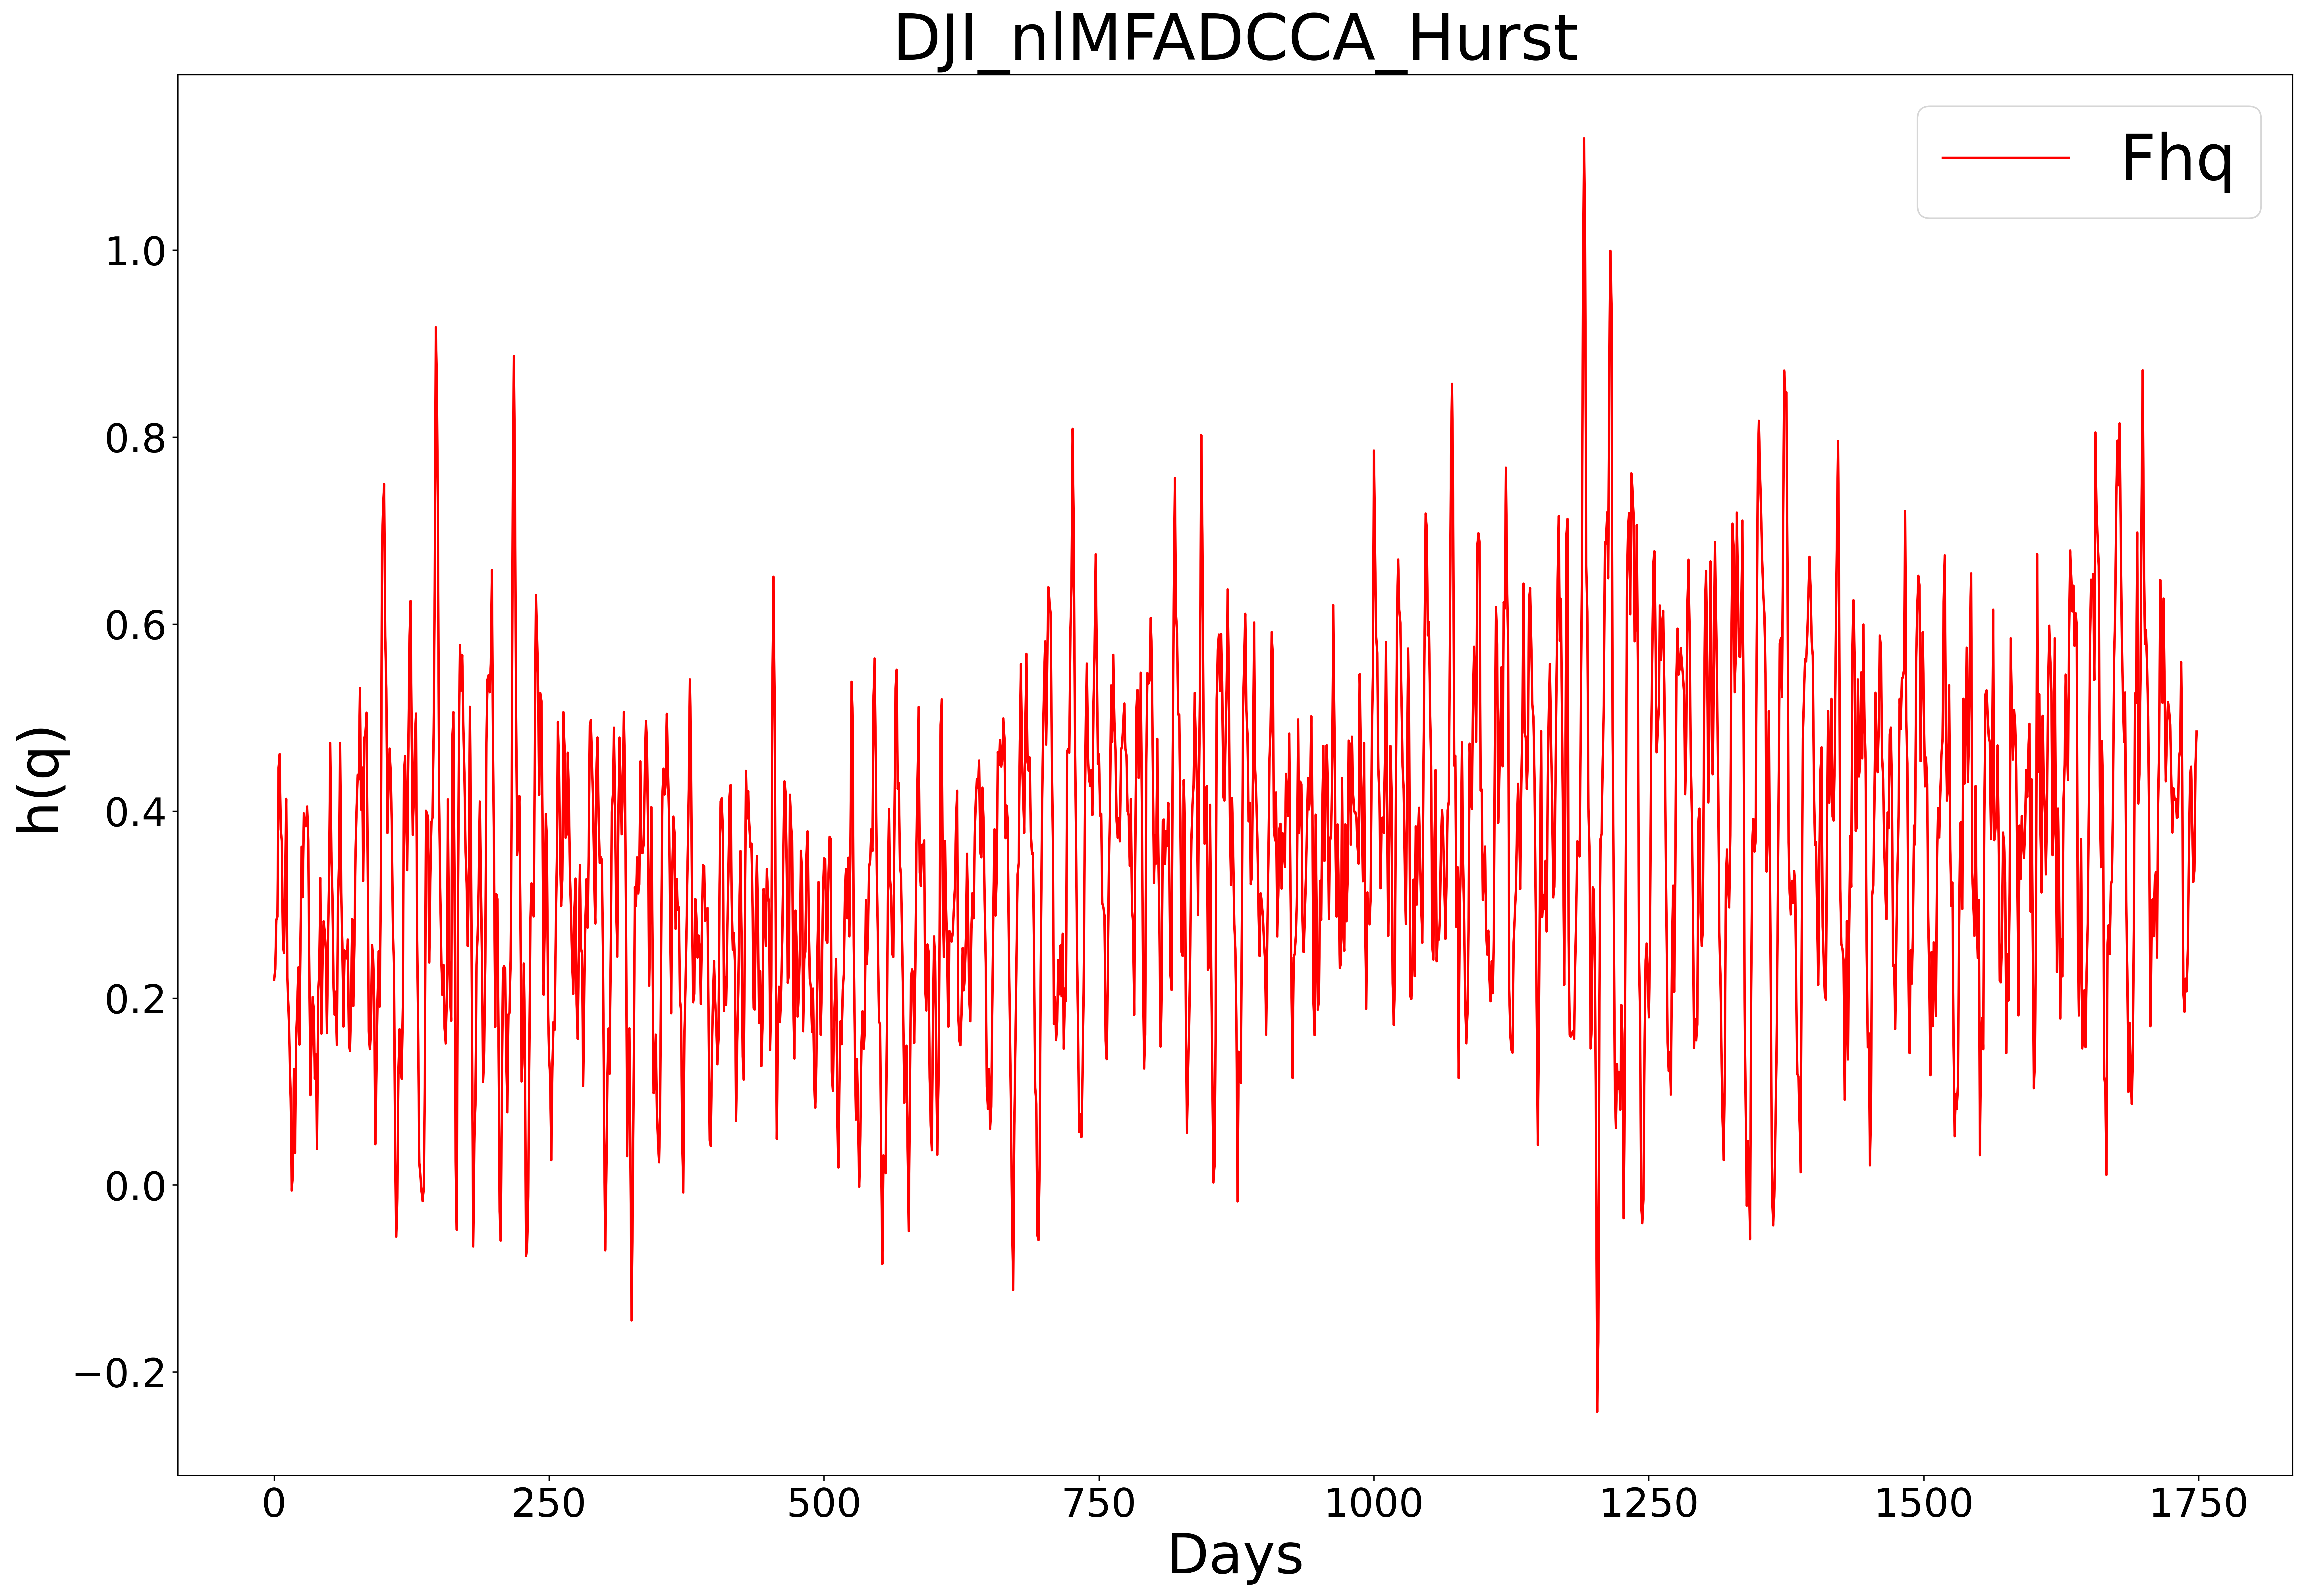

In [13]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst,color='r')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('DJI_nlMFADCCA_Hurst', fontsize=40)
plt.legend(['Fhq'],fontsize=40)
plt.savefig('./pic/DJI_pic/DJI_nlMFADCCA_hurst.png')
plt.show()

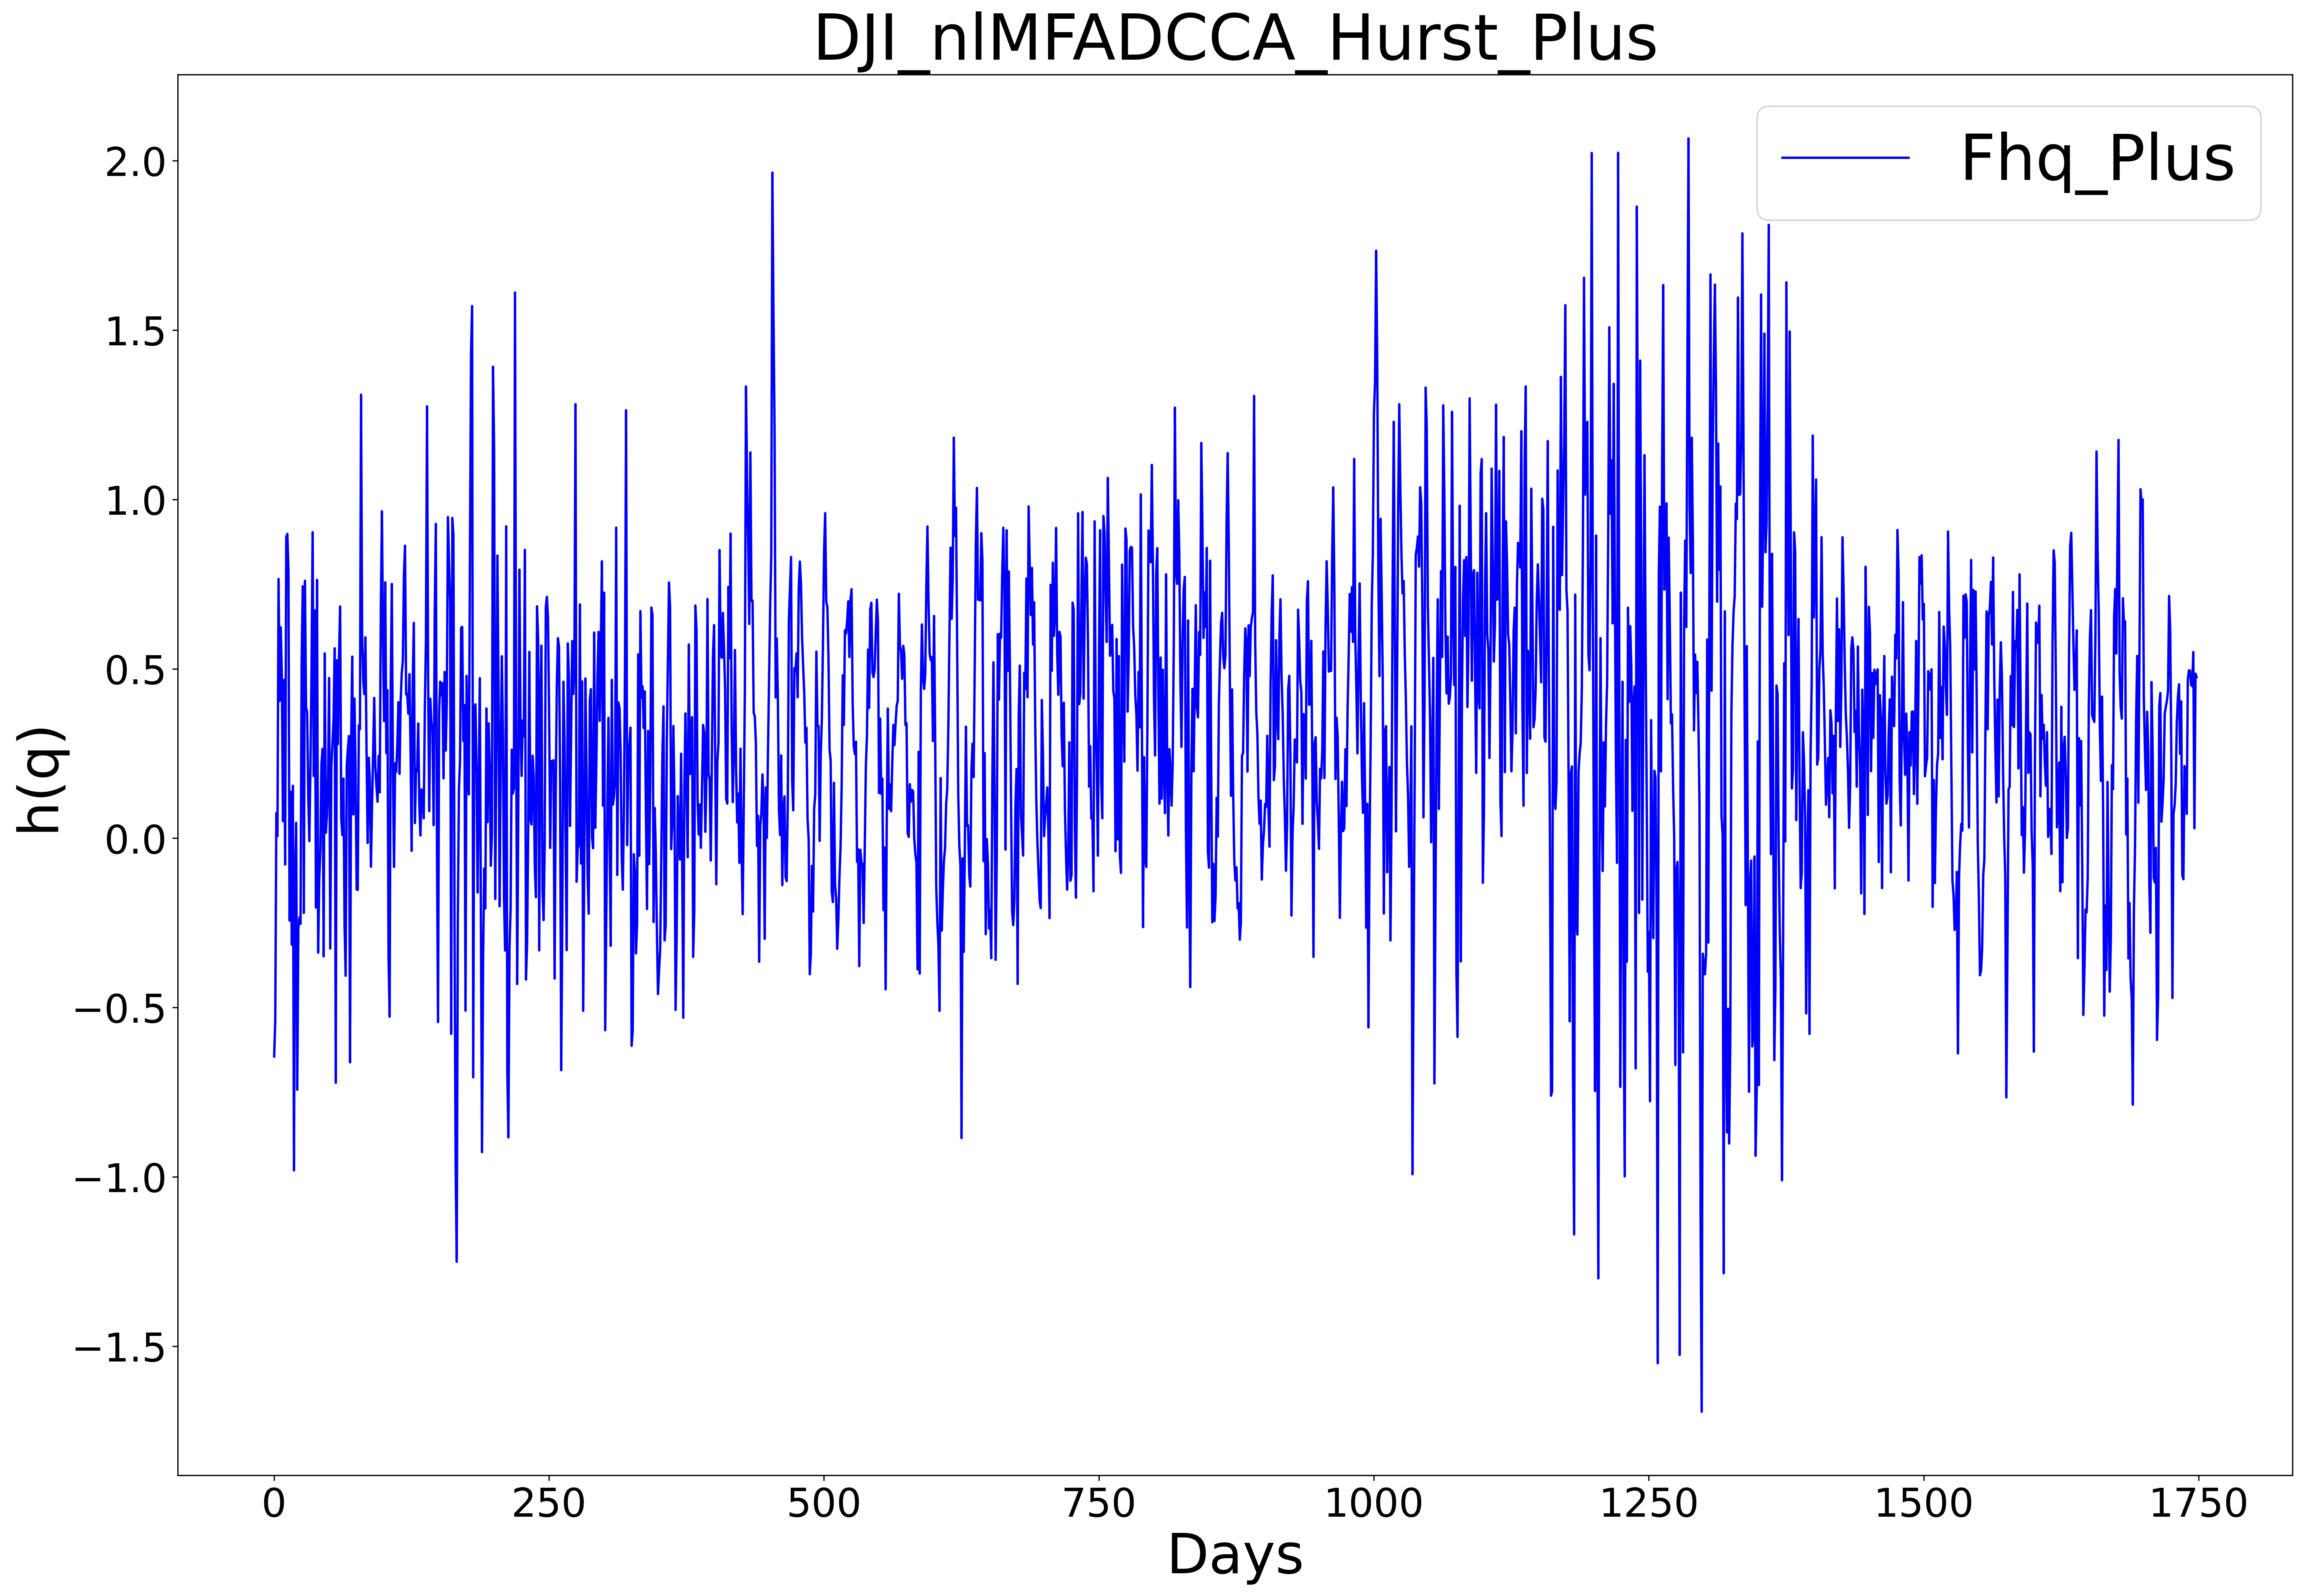

In [14]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_plus,color='b')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('DJI_nlMFADCCA_Hurst_Plus', fontsize=40)
plt.legend(['Fhq_Plus'],fontsize=40)
plt.savefig('./pic/DJI_pic/DJI_nlMFADCCA_hurstplus.png')
plt.show()

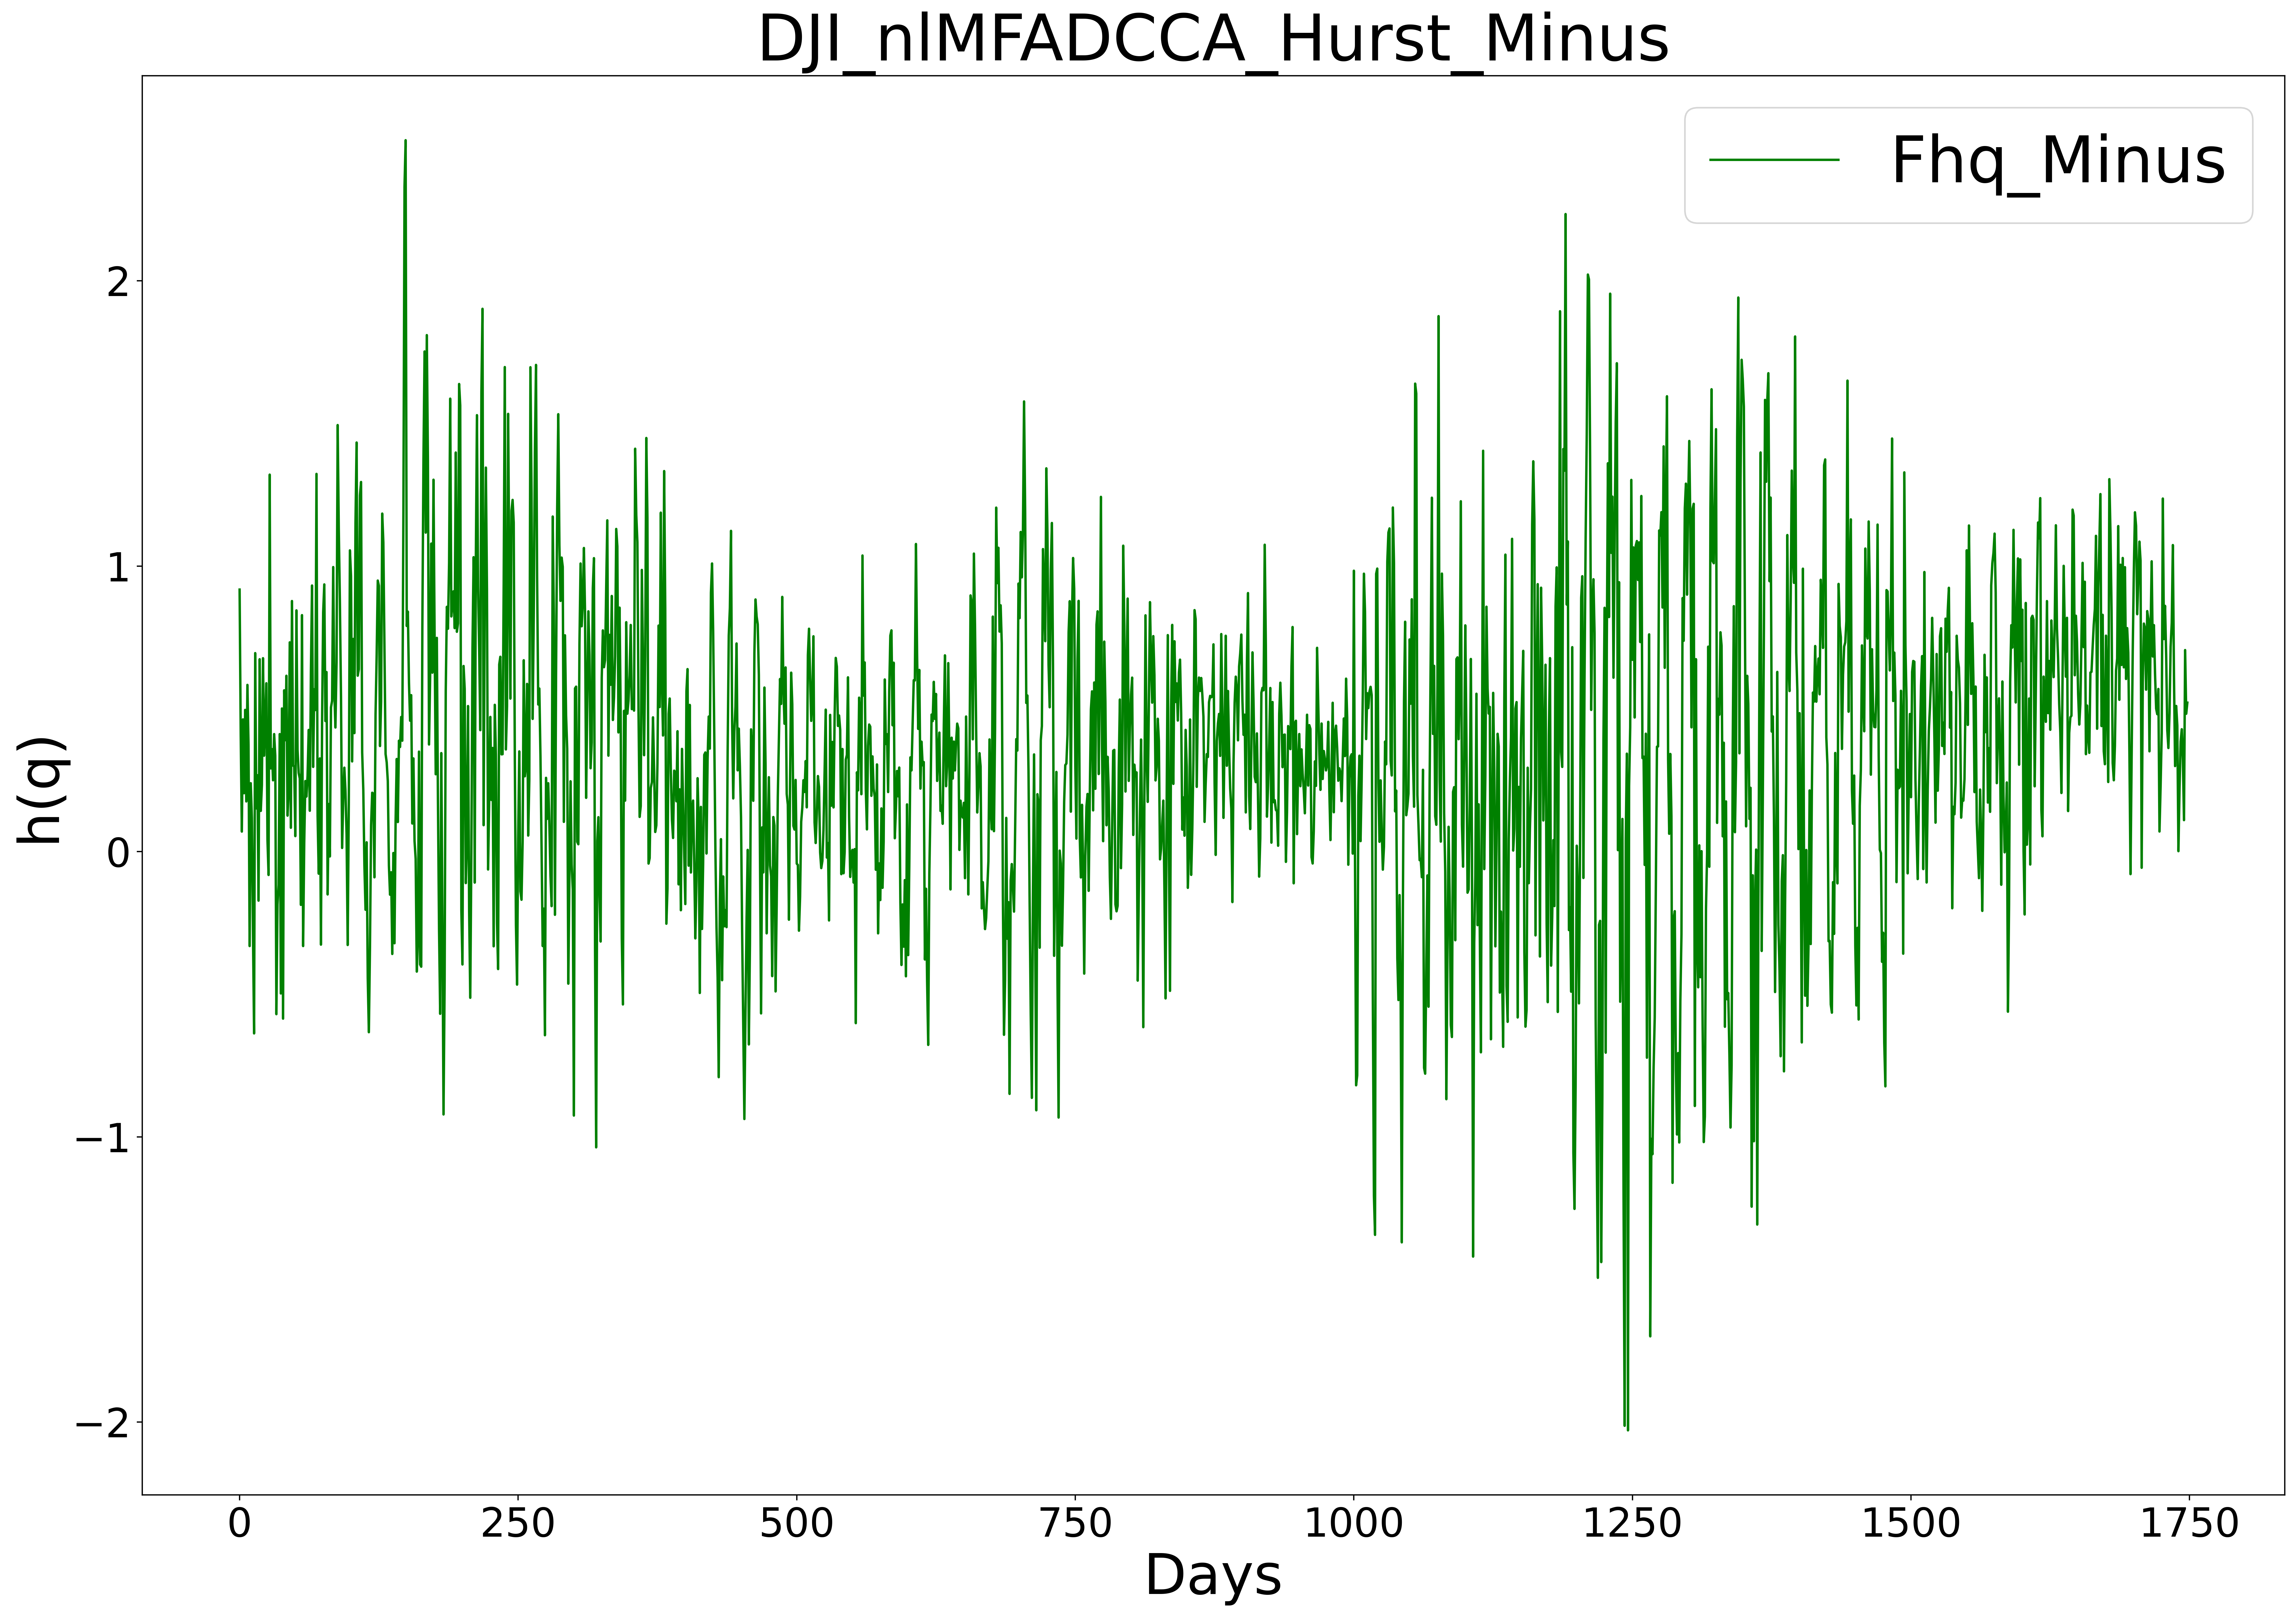

In [15]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_minus,color='g')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('DJI_nlMFADCCA_Hurst_Minus', fontsize=40)
plt.legend(['Fhq_Minus'],fontsize=40)
plt.savefig('./pic/DJI_pic/DJI_nlMFADCCA_hurstminus.png')
plt.show()